# Banking Telemarketing dataset

### In this notebook, we'll explore a telemarketing dataset from a portugese bank

#### We use

<ul>
    <li>Bayesian Search For Parameter Tuning</li>
    <li>Synthetic Minority Over-sampling Technique(SMOTE) for balancing our data set</li>
    <li>Read, Cleanse and Transform the data set with pandas</li>
    <li>Build a Neural Network using Keras' sci-kit learn api</li>
</ul>

https://archive.ics.uci.edu/ml/datasets/bank+marketing

http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf

## Import packages

In [1]:
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense, AlphaDropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import Normalizer, QuantileTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

### Helper function to get and process the data

In [3]:
def dataget(data_path, delimiter=','):

    df = pd.read_csv(data_path,delimiter=delimiter)
    df.pdays.replace(to_replace=[-1], value=999, inplace=True)
    #Convert days before last call to months before last call, simpler feature with lesser variation
    df.pdays = df.pdays.apply(lambda x: int(x/30))
    #Convert day feature to week, knowing pattern of customer across weeks of the month gives simpler and more robust feature 
    df.day = df.day.apply(lambda x: int(x/7))
    categories = ['day', 'month', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y']
#Additional information regarding the sales team member-contacted customer like sales team member language fluency,languages,customer languages would give better insights
#Type of campain count should be made, a text campaign is less annoying,almost not noticeable consciously yet could be imbed the pitch subconsciously.
#Voiced campaigns if performed in excess could loose client trust.
#An interesting experiment with business value would be in determining the mean of this distrust point and campaining accordingly,
    df[categories] = df[categories].apply(lambda x: x.astype('category'))
    df = df.round(2)
    df = pd.get_dummies(df, drop_first=True)
    return df

## Neural Network

In [4]:
def build_model(optimizer=Adam(amsgrad=True),
                total_features=1,
                activation1='elu',
                activation2='elu',
                units1=1,
                units2=1,
                dropout1=0.3,
                dropout2=0.3,
                multi_layer=False,
                op_activation='sigmoid',
                loadprevmodel=False,
                modelname='Bank-Full-best'
               ):
    if loadprevmodel:
        try:
            model = load_model(modelname + '.h5')
            print('Model loaded successfully')
        except IOError:
            print('Loading previous model failed, Building a new model')       
    model = Sequential()
    model.add(Dense(input_dim=total_features, activation=activation1, units=units1))
    if activation1 == 'selu':
        model.add(AlphaDropout(dropout1))
    else:
        model.add(BatchNormalization())
    if multi_layer:
        model.add(Dense(activation=activation2, units=units2))
        if activation2 == 'selu':
            model.add(AlphaDropout(dropout2))
        else:
            model.add(BatchNormalization())
    model.add(Dense(units=1, activation=op_activation))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
data_path = 'bank-full.csv'
original = dataget(data_path, delimiter=';')
df = original.copy()
#df.dropna(inplace=True)
print(df.head(10))

   age  balance  duration  campaign  pdays  previous  job_blue-collar  \
0   58     2143       261         1     33         0                0   
1   44       29       151         1     33         0                0   
2   33        2        76         1     33         0                0   
3   47     1506        92         1     33         0                1   
4   33        1       198         1     33         0                0   
5   35      231       139         1     33         0                0   
6   28      447       217         1     33         0                0   
7   42        2       380         1     33         0                0   
8   58      121        50         1     33         0                0   
9   43      593        55         1     33         0                0   

   job_entrepreneur  job_housemaid  job_management  ...    month_jun  \
0                 0              0               1  ...            0   
1                 0              0               0  

In [6]:
print(df.describe())

                age        balance      duration      campaign         pdays  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058    258.163080      2.763841     28.260932   
std       10.618762    3044.765829    257.527812      3.098021     10.158260   
min       18.000000   -8019.000000      0.000000      1.000000      0.000000   
25%       33.000000      72.000000    103.000000      1.000000     33.000000   
50%       39.000000     448.000000    180.000000      2.000000     33.000000   
75%       48.000000    1428.000000    319.000000      3.000000     33.000000   
max       95.000000  102127.000000   4918.000000     63.000000     33.000000   

           previous  job_blue-collar  job_entrepreneur  job_housemaid  \
count  45211.000000     45211.000000      45211.000000   45211.000000   
mean       0.580323         0.215257          0.032890       0.027427   
std        2.303441         0.411005          0.178351      

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 46 columns):
age                    45211 non-null int64
balance                45211 non-null int64
duration               45211 non-null int64
campaign               45211 non-null int64
pdays                  45211 non-null int64
previous               45211 non-null int64
job_blue-collar        45211 non-null uint8
job_entrepreneur       45211 non-null uint8
job_housemaid          45211 non-null uint8
job_management         45211 non-null uint8
job_retired            45211 non-null uint8
job_self-employed      45211 non-null uint8
job_services           45211 non-null uint8
job_student            45211 non-null uint8
job_technician         45211 non-null uint8
job_unemployed         45211 non-null uint8
job_unknown            45211 non-null uint8
marital_married        45211 non-null uint8
marital_single         45211 non-null uint8
education_secondary    45211 non-null uint8
education_t

In [8]:
search = True
modelh5 = 'Bank-Full'
loadmodelh5 = modelh5 + '-best'
batch_size = 4096
epochs = 200
normalizer = Normalizer(norm='l1')
y_train = df['y_yes'].values
x_train = df.drop(columns=['y_yes']).values
quantile_transformer = QuantileTransformer(output_distribution='normal')
X_train = normalizer.fit_transform(x_train)
#X_train = quantile_transformer.fit_transform(x_train)

In [9]:
params_dict ={'dropout1': Real(0.01, 1.0, 'log-uniform'),
              'dropout2': Real(0.01, 1.0, 'log-uniform'),
              'units1': Integer(int(X_train.shape[1]/2), int(X_train.shape[1] * 2)),
              'units2': Integer(1,5),
              'activation1': Categorical(['elu', 'relu', 'selu']),
              'activation2': Categorical(['elu', 'relu', 'selu']),
              'multi_layer': Categorical([True,False])
        }
if search:
    bayes_search = BayesSearchCV(estimator=KerasClassifier(build_model,
                                                            total_features=X_train.shape[1],
                                                            batch_size=batch_size,
                                                            epochs=epochs,
                                                            verbose=0
                                                           ),
                                  search_spaces=params_dict,
                                  scoring='roc_auc',
                                  n_iter=2,
                                  cv=5,
                                  verbose=3
                                 )

    start = time()
    bayes_search.fit(X_train, y_train)
    print("BayesSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % ((time() - start), bayes_search.total_iterations))

    print("val. score: %s" % bayes_search.best_score_)
    print("test score: %s" % bayes_search.score(X_train, y_train))
    print(bayes_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] activation1=elu, activation2=elu, dropout1=0.11614918367633877, dropout2=0.012039496660731721, multi_layer=True, units1=72, units2=5 
[CV]  activation1=elu, activation2=elu, dropout1=0.11614918367633877, dropout2=0.012039496660731721, multi_layer=True, units1=72, units2=5, score=0.9515067061749809, total= 1.0min
[CV] activation1=elu, activation2=elu, dropout1=0.11614918367633877, dropout2=0.012039496660731721, multi_layer=True, units1=72, units2=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  activation1=elu, activation2=elu, dropout1=0.11614918367633877, dropout2=0.012039496660731721, multi_layer=True, units1=72, units2=5, score=0.9157383896558279, total= 1.0min
[CV] activation1=elu, activation2=elu, dropout1=0.11614918367633877, dropout2=0.012039496660731721, multi_layer=True, units1=72, units2=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV]  activation1=elu, activation2=elu, dropout1=0.11614918367633877, dropout2=0.012039496660731721, multi_layer=True, units1=72, units2=5, score=0.8694416579888479, total= 1.1min
[CV] activation1=elu, activation2=elu, dropout1=0.11614918367633877, dropout2=0.012039496660731721, multi_layer=True, units1=72, units2=5 
[CV]  activation1=elu, activation2=elu, dropout1=0.11614918367633877, dropout2=0.012039496660731721, multi_layer=True, units1=72, units2=5, score=0.7973810032348452, total= 1.1min
[CV] activation1=elu, activation2=elu, dropout1=0.11614918367633877, dropout2=0.012039496660731721, multi_layer=True, units1=72, units2=5 
[CV]  activation1=elu, activation2=elu, dropout1=0.11614918367633877, dropout2=0.012039496660731721, multi_layer=True, units1=72, units2=5, score=0.7366078220813058, total= 1.0min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] activation1=elu, activation2=selu, dropout1=0.07592649847070836, dropout2=0.03554546270573857, multi_layer=True, units

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.3min finished


[CV]  activation1=elu, activation2=selu, dropout1=0.07592649847070836, dropout2=0.03554546270573857, multi_layer=True, units1=70, units2=5, score=0.9578884131027877, total= 1.1min
[CV] activation1=elu, activation2=selu, dropout1=0.07592649847070836, dropout2=0.03554546270573857, multi_layer=True, units1=70, units2=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  activation1=elu, activation2=selu, dropout1=0.07592649847070836, dropout2=0.03554546270573857, multi_layer=True, units1=70, units2=5, score=0.9249126698394011, total= 1.0min
[CV] activation1=elu, activation2=selu, dropout1=0.07592649847070836, dropout2=0.03554546270573857, multi_layer=True, units1=70, units2=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV]  activation1=elu, activation2=selu, dropout1=0.07592649847070836, dropout2=0.03554546270573857, multi_layer=True, units1=70, units2=5, score=0.8775437155076603, total= 1.0min
[CV] activation1=elu, activation2=selu, dropout1=0.07592649847070836, dropout2=0.03554546270573857, multi_layer=True, units1=70, units2=5 
[CV]  activation1=elu, activation2=selu, dropout1=0.07592649847070836, dropout2=0.03554546270573857, multi_layer=True, units1=70, units2=5, score=0.7764115517283557, total= 1.0min
[CV] activation1=elu, activation2=selu, dropout1=0.07592649847070836, dropout2=0.03554546270573857, multi_layer=True, units1=70, units2=5 
[CV]  activation1=elu, activation2=selu, dropout1=0.07592649847070836, dropout2=0.03554546270573857, multi_layer=True, units1=70, units2=5, score=0.7926810313520818, total= 1.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished


BayesSearchCV took 715.92 seconds for 14 candidates parameter settings.
val. score: 0.8658895112297882
test score: 0.9004828890717692
{'activation1': 'elu', 'activation2': 'selu', 'dropout1': 0.07592649847070836, 'dropout2': 0.03554546270573857, 'multi_layer': True, 'units1': 70, 'units2': 5}


## 5 fold CV's val and test score seems good, let's train on entire data set and measure the AUC

In [10]:
%%time
#params = {'units': 20, 'multi_layer': False, 'dropout_value': 0.31, 'activation': 'relu'} quantile
#params = {'activation1': 'selu', 'activation2': 'relu', 'dropout1': 0.16996101875678074, 'dropout2': 0.298349550832899, 'multi_layer': False, 'units1': 56, 'units2': 5}
#params = {'activation1': 'selu', 'activation2': 'selu', 'dropout1': 0.019682754459910985, 'dropout2': 0.3288644376833346, 'multi_layer': False, 'units1': 45, 'units2': 2}
params = {'activation1': 'elu', 'activation2': 'selu', 'dropout1': 0.07592649847070836, 'dropout2': 0.03554546270573857, 'multi_layer': True, 'units1': 70, 'units2': 5}
clf = KerasClassifier(build_model,
                      total_features=X_train.shape[1],
                      batch_size=4096,
                      epochs=200,
                      verbose=1,
                     **params)

smote = SMOTE(kind = "regular")
X_sm, y_sm = smote.fit_sample(X_train, y_train)
clf.fit(X_sm, y_sm)
y_true, y_pred = y_train, clf.predict(X_train)

Epoch 1/200
79844/79844 [==============================] - 5s 58us/step - loss: 0.5564 - acc: 0.7245
Epoch 2/200
79844/79844 [==============================] - 1s 9us/step - loss: 0.5144 - acc: 0.7528
Epoch 3/200
79844/79844 [==============================] - 1s 10us/step - loss: 0.4981 - acc: 0.7644
Epoch 4/200
79844/79844 [==============================] - 1s 10us/step - loss: 0.4864 - acc: 0.7713
Epoch 5/200
79844/79844 [==============================] - 1s 9us/step - loss: 0.4721 - acc: 0.7814
Epoch 6/200
79844/79844 [==============================] - 1s 8us/step - loss: 0.4610 - acc: 0.7859
Epoch 7/200
79844/79844 [==============================] - 1s 8us/step - loss: 0.4484 - acc: 0.7953A: 0s - loss: 0.4465 - acc
Epoch 8/200
79844/79844 [==============================] - 0s 6us/step - loss: 0.4447 - acc: 0.7927
Epoch 9/200
79844/79844 [==============================] - 1s 7us/step - loss: 0.4339 - acc: 0.8026
Epoch 10/200
79844/79844 [==============================] - 1s 7us/step

79844/79844 [==============================] - 0s 6us/step - loss: 0.3748 - acc: 0.8404
Epoch 82/200
79844/79844 [==============================] - 0s 6us/step - loss: 0.3741 - acc: 0.8404
Epoch 83/200
79844/79844 [==============================] - 0s 6us/step - loss: 0.3766 - acc: 0.8374
Epoch 84/200
79844/79844 [==============================] - 1s 7us/step - loss: 0.3731 - acc: 0.8415
Epoch 85/200
79844/79844 [==============================] - 1s 7us/step - loss: 0.3729 - acc: 0.8412
Epoch 86/200
79844/79844 [==============================] - 1s 7us/step - loss: 0.3717 - acc: 0.8421
Epoch 87/200
79844/79844 [==============================] - 1s 7us/step - loss: 0.3720 - acc: 0.8420
Epoch 88/200
79844/79844 [==============================] - 1s 9us/step - loss: 0.3709 - acc: 0.8427
Epoch 89/200
79844/79844 [==============================] - 1s 10us/step - loss: 0.3705 - acc: 0.8430
Epoch 90/200
79844/79844 [==============================] - 1s 10us/step - loss: 0.3707 - acc: 0.8441
E

79844/79844 [==============================] - 1s 9us/step - loss: 0.3625 - acc: 0.8469
Epoch 161/200
79844/79844 [==============================] - 1s 11us/step - loss: 0.3662 - acc: 0.8430
Epoch 162/200
79844/79844 [==============================] - 1s 10us/step - loss: 0.3636 - acc: 0.8461
Epoch 163/200
79844/79844 [==============================] - 1s 9us/step - loss: 0.3656 - acc: 0.8435
Epoch 164/200
79844/79844 [==============================] - 1s 9us/step - loss: 0.3618 - acc: 0.8461
Epoch 165/200
79844/79844 [==============================] - 1s 9us/step - loss: 0.3612 - acc: 0.8472
Epoch 166/200
79844/79844 [==============================] - 1s 8us/step - loss: 0.3650 - acc: 0.8448
Epoch 167/200
79844/79844 [==============================] - 1s 9us/step - loss: 0.3649 - acc: 0.8447
Epoch 168/200
79844/79844 [==============================] - 1s 7us/step - loss: 0.3615 - acc: 0.8473
Epoch 169/200
79844/79844 [==============================] - 0s 6us/step - loss: 0.3613 - acc:

45211/45211 [==============================] - 0s 4us/step
AUC=0.9055711672361219
             precision    recall  f1-score   support

          0       0.97      0.84      0.90     39922
          1       0.40      0.80      0.53      5289

avg / total       0.90      0.84      0.86     45211



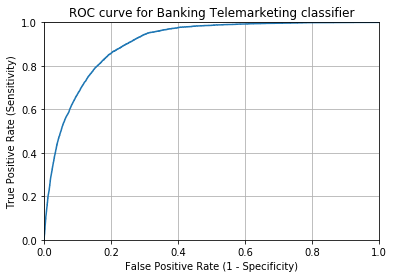

In [13]:
y_proba = clf.predict_proba(X_train)[:,1]
score = roc_auc_score(y_true, y_proba)
print(f'AUC={score}')
print(classification_report(y_true, y_pred))
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Banking Telemarketing classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# AUC of 0.9 is a good score
## 80% of the minority class(relevant class) is classified correctly
### Significant time,resources can be saved by telemarketing calls to new users who have similar data and we can expect good ROI on this